In [1]:
!gdown https://drive.google.com/uc?id=1zs2RPZkLeB5QDRVQtpqUtMwepR_Qfufp
!unzip -q facades.zip

Downloading...
From: https://drive.google.com/uc?id=1zs2RPZkLeB5QDRVQtpqUtMwepR_Qfufp
To: /content/facades.zip
100% 26.1M/26.1M [00:00<00:00, 98.8MB/s]


In [2]:
!pip install -qqq tensorflow_addons

     |████████████████████████████████| 1.1 MB 4.2 MB/s 


In [3]:
import os
import numpy as np
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import (
    layers, losses, initializers, applications,
    optimizers, callbacks, models, Model, Input
)

In [4]:
IMAGE_SIZE = 256
N_CLASSES = 12
LATENT_DIM = 256
BATCH_SIZE = 16

## Dataloader

In [5]:
def random_crop(image, segmentation_map, labels):
    image_shape = tf.shape(image)[:2]
    width = tf.random.uniform(
        shape=(), maxval=image_shape[1] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    height = tf.random.uniform(
        shape=(), maxval=image_shape[0] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    image_cropped = image[
        height : height + IMAGE_SIZE, width : width + IMAGE_SIZE
    ]
    segmentation_map_cropped = segmentation_map[
        height : height + IMAGE_SIZE, width : width + IMAGE_SIZE
    ]
    labels_cropped = labels[
        height : height + IMAGE_SIZE, width : width + IMAGE_SIZE
    ]
    return image_cropped, segmentation_map_cropped, labels_cropped


def one_hot_encode(image, labels):
    h, w, _ = image.shape
    one_hot_encoded_labels = np.zeros((h, w, N_CLASSES), dtype=np.float32)
    for i in range(N_CLASSES):
        one_hot_encoded_labels[labels == i, i] = 1
    return one_hot_encoded_labels


def load_data(image_file, segmentation_map_file, label_file):
    image_file = image_file.numpy().decode("utf-8")
    segmentation_map_file = segmentation_map_file.numpy().decode("utf-8")
    label_file = label_file.numpy().decode("utf-8")
    image = np.array(Image.open(image_file))
    segmentation_map = np.array(Image.open(segmentation_map_file))
    labels = np.array(Image.open(label_file), dtype=np.uint8)
    image = image / 127.5 - 1
    segmentation_map = segmentation_map / 127.5 - 1
    one_hot_encoded_labels = one_hot_encode(image, labels)
    return image, segmentation_map, one_hot_encoded_labels


def parse_fn(image_file, segmentation_map_file, label_file):
    return tf.py_function(
        load_data,
        [image_file, segmentation_map_file, label_file],
        [tf.float32, tf.float32, tf.float32],
    )

In [6]:
def get_batched_dataset(image_files, batch_size):
    segmentation_map_files = [
        image_file.replace("images", "segmentation_map").replace("jpg", "png")
        for image_file in image_files
    ]
    label_files = [
        image_file.replace("images", "segmentation_labels").replace("jpg", "bmp")
        for image_file in image_files
    ]
    dataset = tf.data.Dataset.from_tensor_slices(
        (image_files, segmentation_map_files, label_files)
    )
    dataset = dataset.shuffle(256)
    dataset = dataset.map(parse_fn, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(random_crop, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset


def get_datasets(dataset_path, val_split=0.2, batch_size=16):
    image_files = glob(os.path.join(dataset_path, "images", "*"))
    split_index = int(len(image_files) * (1 - val_split))
    train_image_files = image_files[:split_index]
    val_image_files = image_files[split_index:]
    train_dataset = get_batched_dataset(train_image_files, batch_size)
    val_dataset = get_batched_dataset(val_image_files, batch_size)
    return train_dataset, val_dataset


train_dataset, val_dataset = get_datasets(dataset_path="./facades/")

image shape: (16, 256, 256, 3)
segmentation_map shape: (16, 256, 256, 3)
one_hot_encoded_labels shape: (16, 256, 256, 12)


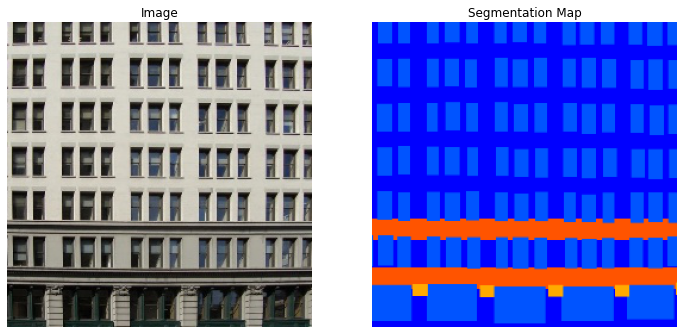

image shape: (16, 256, 256, 3)
segmentation_map shape: (16, 256, 256, 3)
one_hot_encoded_labels shape: (16, 256, 256, 12)


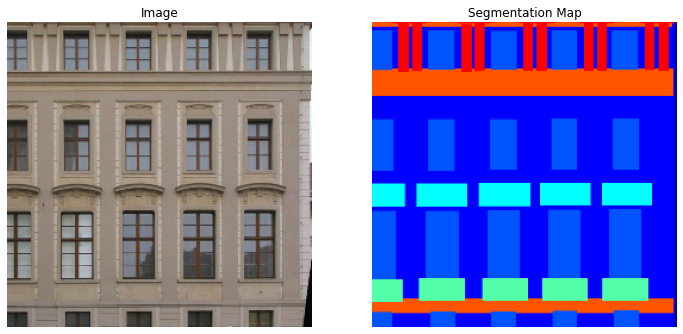

image shape: (16, 256, 256, 3)
segmentation_map shape: (16, 256, 256, 3)
one_hot_encoded_labels shape: (16, 256, 256, 12)


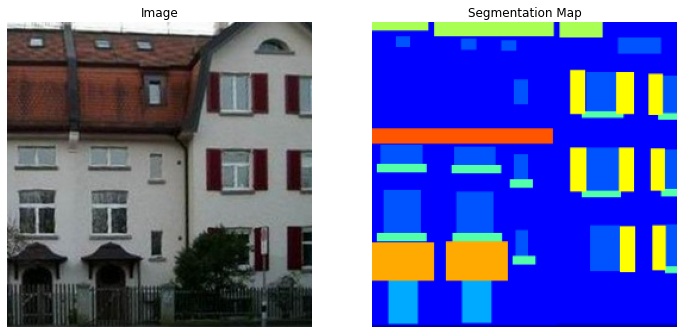

image shape: (16, 256, 256, 3)
segmentation_map shape: (16, 256, 256, 3)
one_hot_encoded_labels shape: (16, 256, 256, 12)


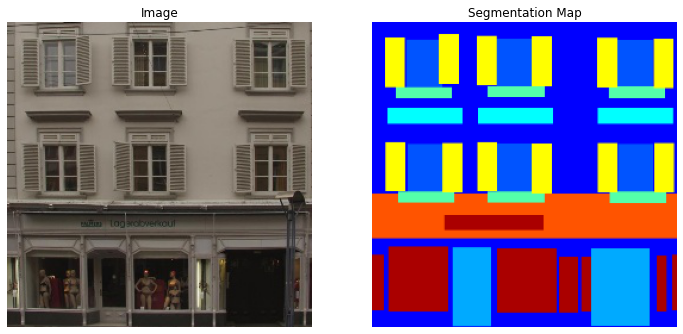

image shape: (16, 256, 256, 3)
segmentation_map shape: (16, 256, 256, 3)
one_hot_encoded_labels shape: (16, 256, 256, 12)


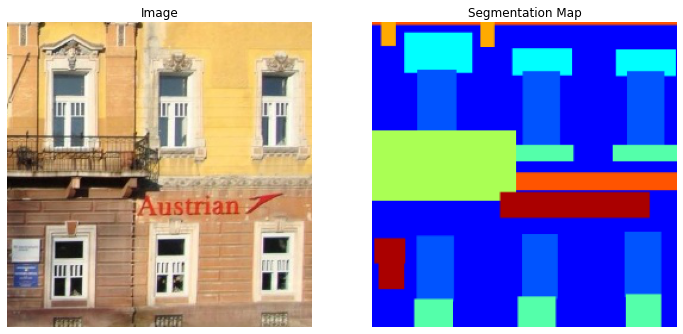

In [7]:
def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()


for _ in range(5):
    image, segmentation_map, one_hot_encoded_labels = next(iter(train_dataset))

    print("image shape:", image.shape)
    print("segmentation_map shape:", segmentation_map.shape)
    print("one_hot_encoded_labels shape:", one_hot_encoded_labels.shape)

    sample_image = (image.numpy()[0] + 1) * 127.5
    sample_segmentation_map = (segmentation_map.numpy()[0] + 1) * 127.5
    sample_one_hot_encoded_labels = one_hot_encoded_labels.numpy()[0]

    plot_results(
        [
            sample_image.astype(np.uint8),
            sample_segmentation_map.astype(np.uint8)
        ],
        ["Image", "Segmentation Map"]
    )

## Model

In [8]:
class SPADE(layers.Layer):
    
    def __init__(self, filters, epsilon=1e-5, *args, **kwargs):
        super(SPADE, self).__init__(*args, **kwargs)
        self.epsilon = epsilon
        self.conv = layers.Conv2D(
            128, 3, padding='same', activation='relu')
        self.conv_gamma = layers.Conv2D(filters, 3, padding='same')
        self.conv_beta = layers.Conv2D(filters, 3, padding='same')
        
    def build(self, input_shape):
        self.resize_shape = input_shape[1:3]
        
    def call(self, input_tensor, raw_mask):
        mask = tf.image.resize(
            raw_mask, self.resize_shape, method='nearest')
        x = self.conv(mask)
        gamma = self.conv_gamma(x)
        beta = self.conv_beta(x)
        mean, var = tf.nn.moments(
            input_tensor, axes=(0, 1, 2), keepdims=True)
        std = tf.sqrt(var + self.epsilon)
        normalized = (input_tensor - mean) / std
        return gamma * normalized + beta

In [9]:
class Resblock(layers.Layer):
    
    def __init__(self, filters, *args, **kwargs):
        super(Resblock, self).__init__(*args, **kwargs)
        self.filters = filters
        
    def build(self, input_shape):
        input_filter = input_shape[-1]
        self.spade_1 = SPADE(input_filter)
        self.spade_2 = SPADE(self.filters)
        self.conv_1 = layers.Conv2D(self.filters, 3, padding='same')
        self.conv_2 = layers.Conv2D(self.filters, 3, padding='same')
        self.learned_skip = False    
        if self.filters != input_filter:
            self.learned_skip = True
            self.spade_3 = SPADE(input_filter)
            self.conv_3 = layers.Conv2D(
                self.filters, 3, padding='same')        
        
    def call(self, input_tensor, mask):
        x = self.spade_1(input_tensor, mask)
        x = self.conv_1(tf.nn.leaky_relu(x, 0.2))
        x = self.spade_2(x, mask)
        x = self.conv_2(tf.nn.leaky_relu(x, 0.2))
        skip = self.conv_3(tf.nn.leaky_relu(
            self.spade_3(input_tensor, mask), 0.2
        )) if self.learned_skip else input_tensor
        return skip + x

In [10]:
class GaussianSampler(layers.Layer):       
    
    def __init__(self, batch_size, latent_dim, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.batch_size = batch_size
        self.latent_dim = latent_dim
        
    def call(self, inputs):
        means, variance = inputs
        epsilon = tf.random.normal(
            shape=(self.batch_size, self.latent_dim), mean=0., stddev=1.)
        return means + tf.exp(0.5 * variance) * epsilon

In [11]:
def downsample_block(input_tensor, channels, kernels, strides=2, apply_norm=True, apply_activation=True, apply_dropout=False):
    x = layers.Conv2D(
        channels, kernels, strides=strides, padding='same',
        use_bias=False, kernel_initializer=initializers.GlorotNormal()
    )(input_tensor)
    x = tfa.layers.InstanceNormalization()(x) if apply_norm else x
    x = layers.LeakyReLU(0.2)(x) if apply_activation else x
    x = layers.Dropout(0.5)(x) if apply_dropout else x
    return x


def build_encoder(encoder_dim=64):
    input_image = Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3])
    x = downsample_block(input_image, encoder_dim, 3, apply_norm=False)
    x = downsample_block(x, 2 * encoder_dim, 3) 
    x = downsample_block(x, 4 * encoder_dim, 3) 
    x = downsample_block(x, 8 * encoder_dim, 3) 
    x = downsample_block(x, 8 * encoder_dim, 3) 
    x = layers.Flatten()(x)
    mean = layers.Dense(LATENT_DIM, name='mean')(x)
    variance = layers.Dense(LATENT_DIM, name='variance')(x)
    return Model(input_image, [mean, variance], name='encoder')

In [12]:
def build_generator():
    latent_input = Input(shape=(LATENT_DIM))
    label_map_input  = layers.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, N_CLASSES])
    x = layers.Dense(16384)(latent_input)
    x = layers.Reshape((4, 4, 1024))(x)
    x = Resblock(filters=1024)(x, label_map_input)
    x = layers.UpSampling2D((2, 2))(x)
    x = Resblock(filters=1024)(x, label_map_input)
    x = layers.UpSampling2D((2, 2))(x)
    x = Resblock(filters=1024)(x, label_map_input)
    x = layers.UpSampling2D((2, 2))(x)
    x = Resblock(filters=512)(x, label_map_input)
    x = layers.UpSampling2D((2, 2))(x)
    x = Resblock(filters=256)(x, label_map_input)
    x = layers.UpSampling2D((2, 2))(x)
    x = Resblock(filters=128)(x, label_map_input)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.LeakyReLU(0.2)(x)
    output_image = layers.Conv2D(3, 4, padding='same', activation="tanh")(x)
    return Model(
        [latent_input, label_map_input], output_image, name='generator'
    )

In [13]:
def build_discriminator(downsample_factor=64):
    image_A = Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3])
    image_B = Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3])
    x = layers.Concatenate()([image_A, image_B])
    x1 = downsample_block(x, downsample_factor, 4, apply_norm=False)
    x2 = downsample_block(x1, 2 * downsample_factor, 4)
    x3 = downsample_block(x2, 4 * downsample_factor, 4)
    x4 = downsample_block(x3, 8 * downsample_factor, 4)
    x5 = layers.Conv2D(1, 4)(x4)
    return Model([image_A, image_B], [x1, x2, x3, x4, x5], name="discriminator")

## Loss Functions

In [14]:
def kl_divergence_loss(mean, variance):
    return - 0.5 * tf.reduce_sum(1 + variance - tf.square(mean) - tf.exp(variance))


def generator_loss(y):
    return -tf.reduce_mean(y)

In [15]:
class ContentLoss(losses.Loss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.encoder_layers = ['block1_conv1',
                               'block2_conv1',
                               'block3_conv1', 
                               'block4_conv1',
                               'block5_conv1']
        self.encoder_weights = [1./32, 1./16, 1./8, 1./4, 1.]
        self.feature_model = self._build_vgg_19()
    
    def _build_vgg_19(self):
        vgg = applications.VGG19(include_top=False, weights='imagenet')
        layer_outputs = [vgg.get_layer(x).output for x in self.encoder_layers]
        return Model(vgg.input, layer_outputs, name='VGG')
    
    def call(self, real_image, fake_image):
        x = tf.reverse(real_image, axis=[-1])
        y = tf.reverse(fake_image, axis=[-1])
        x =  applications.vgg19.preprocess_input(127.5 * (x + 1))
        y =  applications.vgg19.preprocess_input(127.5 * (y + 1))
        feat_real = self.feature_model(x)
        feat_fake = self.feature_model(y)
        loss = 0
        mae = losses.MeanAbsoluteError()
        for i in range(len(feat_real)):
            loss += self.encoder_weights[i] * mae(feat_real[i], feat_fake[i])
        return loss

## Training

In [22]:
class GauGAN(Model):

    def __init__(
        self,
        encoder_dim=64,
        downsample_factor=64,
        feature_loss_weight=10.0,
        content_loss_weight=0.1,
        kl_divergence_weight=0.1,
        *args, **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.encoder = build_encoder(encoder_dim)
        self.generator = build_generator()
        self.discriminator = build_discriminator(downsample_factor)
        self.sampler = GaussianSampler(BATCH_SIZE, LATENT_DIM)
        self.feature_loss_weight = feature_loss_weight
        self.content_loss_weight = content_loss_weight
        self.kl_divergence_weight = kl_divergence_weight
        self.patch_size = self.discriminator.output_shape[-1][1]
    
    def summary(self, line_length=None, positions=None, print_fn=None):
        self.encoder.summary(line_length, positions, print_fn)
        self.generator.summary(line_length, positions, print_fn)
        self.discriminator.summary(line_length, positions, print_fn)
    
    def compile(self, g_lr, d_lr, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.generator_optimizer = optimizers.Adam(learning_rate=g_lr, beta_1=0.0)
        self.discriminator_optimizer = optimizers.Adam(learning_rate=d_lr, beta_1=0.0)
        self.content_loss = ContentLoss()
        self.discriminator_hinge_loss = losses.Hinge()
        self.mean_absolute_error = losses.MeanAbsoluteError()
    
    def feature_matching_loss(self, real_features, fake_features):
        loss = 0
        for i in range(len(real_features)-1):
            loss +=  self.mean_absolute_error(real_features[i], fake_features[i])
        return loss
    
    def discriminator_train_step(self, latent, real_images_A, real_images_B, labels_A):
        fake_images_B = self.generator([latent, labels_A])
        with tf.GradientTape() as d_tape:
            fake_prediction = self.discriminator([real_images_A, real_images_B])[-1]
            real_prediction = self.discriminator([fake_images_B, real_images_B])[-1]
            fake_loss = self.discriminator_hinge_loss(-1.0, fake_prediction)
            real_loss = self.discriminator_hinge_loss(1.0, real_prediction)
            total_loss = 0.5 * (fake_loss + real_loss)
        gradients = d_tape.gradient(total_loss, self.discriminator.trainable_variables)
        self.discriminator_optimizer.apply_gradients(
            zip(gradients, self.discriminator.trainable_variables)
        )
        return total_loss
    
    def generator_train_step(self, latent, real_images_A, real_images_B, labels_A, mean, variance):
        with tf.GradientTape() as g_tape:
            real_d_output = self.discriminator([real_images_A, real_images_B])
            fake_images = self.generator([latent, labels_A])
            fake_d_output = self.discriminator([fake_images, real_images_B])
            prediction = fake_d_output[-1]
            g_loss = self.discriminator_hinge_loss(1.0, fake_d_output[-1])
            kl_loss = self.kl_divergence_weight * kl_divergence_loss(mean, variance)
            content_loss = self.content_loss_weight * self.content_loss(real_images_A, fake_images)
            feature_loss = self.feature_loss_weight * self.feature_matching_loss(real_d_output, fake_d_output)
            total_loss = g_loss + kl_loss + content_loss + feature_loss
        gradients = g_tape.gradient(total_loss, self.generator.trainable_variables)
        self.generator_optimizer.apply_gradients(
            zip(gradients, self.generator.trainable_variables)
        )
        return g_loss, kl_loss, content_loss, feature_loss
    
    def train_step(self, data):
        real_images_A, real_images_B, labels_A = data
        mean, variance = self.encoder(real_images_B)
        latent_input = self.sampler([mean, variance])
        discriminator_loss = self.discriminator_train_step(
            latent_input, real_images_A, real_images_B, labels_A
        )
        g_loss, kl_loss, content_loss, feature_loss = self.generator_train_step(
            latent_input, real_images_A, real_images_B, labels_A, mean, variance
        )
        return {
            "discriminator_loss": discriminator_loss,
            "generator_loss": g_loss,
            "kl_divergence_loss": kl_loss,
            "content_loss": content_loss,
            "feature_loss": feature_loss
        }
    
    def test_step(self, data):
        real_images_A, real_images_B, labels_A = data
        mean, variance = self.encoder(real_images_B)
        latent_input = self.sampler([mean, variance])
        fake_images_B = self.generator([latent_input, labels_A])
        fake_prediction = self.discriminator([real_images_A, fake_images_B])[-1]
        real_prediction = self.discriminator([real_images_A, real_images_B])[-1]
        fake_loss = self.discriminator_hinge_loss(-1.0, fake_prediction)
        real_loss = self.discriminator_hinge_loss(1.0, real_prediction)
        discriminator_loss = 0.5 * (fake_loss + real_loss)
        real_d_output = self.discriminator([real_images_A, real_images_B])
        fake_images = self.generator([latent_input, labels_A])
        fake_d_output = self.discriminator([fake_images, real_images_B])
        prediction = fake_d_output[-1]
        g_loss = generator_loss(prediction)
        kl_loss = self.kl_divergence_weight * kl_divergence_loss(mean, variance)
        content_loss = self.content_loss_weight * self.content_loss(real_images_A, fake_images)
        feature_loss = self.feature_loss_weight * self.feature_matching_loss(real_d_output, fake_d_output)
        total_generator_loss = g_loss + kl_loss + content_loss + feature_loss
        return {
            "discriminator_loss": discriminator_loss,
            "generator_loss": total_generator_loss,
            "kl_divergence_loss": kl_loss,
            "content_loss": content_loss,
            "feature_loss": feature_loss
        }
    
    def call(self, inputs, *args, **kwargs):
        real_images_B, labels_A = inputs
        mean, variance = self.encoder(real_images_B)
        latent_input = self.sampler([mean, variance])
        generated_images = self.generator([latent_input, labels_A])
        return generated_images
    
    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        self.generator.save_weights(
            filepath + "_generator.h5",
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )
        self.discriminator.save_weights(
            filepath + "_discriminator.h5",
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )

    def load_weights(
        self,
        generator_filepath,
        discriminator_filepath,
        by_name=False,
        skip_mismatch=False,
        options=None,
    ):
        self.generator.load_weights(
            generator_filepath,
            by_name=by_name,
            skip_mismatch=skip_mismatch,
            options=options,
        )
        self.discriminator.load_weights(
            discriminator_filepath,
            by_name=by_name,
            skip_mismatch=skip_mismatch,
            options=options,
        )


In [23]:
gaugan = GauGAN()
gaugan.compile(g_lr=1e-4, d_lr=4e-4)
gaugan.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 128, 128, 64  1728        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_10 (LeakyReLU)     (None, 128, 128, 64  0           ['conv2d_11[0][0]']              
                                )                                                           

In [19]:
def plot_results(images, titles, save_figure=False, figure_size=(12, 12)):
    """Plot results in a row.
    Args:
        images: List of images (PIL or numpy arrays).
        titles: List of titles corresponding to images.
        save_figure: If we are serializing the figure.
        figure_size: Size of figure.
    """
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        if titles:
            fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        else:
            fig.add_subplot(1, len(images), i + 1)
        _ = plt.imshow(images[i])
        plt.axis("off")
    if save_figure:
        return plt
    else:
        plt.show()


class GANMonitor(tf.keras.callbacks.Callback):
    """Monitors the progress of Generator during training."""

    def __init__(self, segmentation_maps, labels, root_dir, epoch_interval=5):
        """Initialize the GANMonitor.
        Args:
            segmentation_maps: NumPy array of segmentation maps (can be tf.Tensor too).
            labels: Numpy array of one-hot encoded labels corresponding to segmentation maps (can be tf.Tensor too).
            root_dir: Root directory where to save the generated images.
            epoch_interval: Interval between epochs to plot.
        """
        self.segmentation_maps = segmentation_maps
        self.labels = labels
        self.root_dir = root_dir
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.epoch_interval == 0:
            generated_images = self.model.predict((self.segmentation_maps, self.labels))
            # Since the generator has tanh activation, we need to map it within [-1, 1] to [0, 1].
            generated_images = generated_images + 1
            generated_images = np.clip(generated_images, 0, 1).astype(np.float32)
            figure_object = plot_results(generated_images, None, save_figure=True)

            if not os.path.exists(os.path.join(self.root_dir, "intermediate_images")):
                os.makedirs(os.path.join(self.root_dir, "intermediate_images"))
            figure_path = os.path.join(
                self.root_dir,
                "intermediate_images",
                f"generated_images_epoch_{epoch}.png",
            )
            figure_object.savefig(figure_path, bbox_inches="tight", dpi=300)

In [24]:
validation_batch = next(iter(val_dataset))
gan_monitor = GANMonitor(
    validation_batch[1], validation_batch[2], "."
)

In [ ]:
history = gaugan.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=[gan_monitor])

Epoch 1/20
18/18 [==============================] - 45s 2s/step - discriminator_loss: 1.2946 - generator_loss: 1.3469 - kl_divergence_loss: 356.0485 - content_loss: 18.6734 - feature_loss: 9.8537 - val_discriminator_loss: 1.0633 - val_generator_loss: 392.4142 - val_kl_divergence_loss: 365.6372 - val_content_loss: 16.7260 - val_feature_loss: 10.1951
Epoch 2/20
18/18 [==============================] - 29s 2s/step - discriminator_loss: 0.8827 - generator_loss: 0.8145 - kl_divergence_loss: 355.8975 - content_loss: 17.6328 - feature_loss: 11.0583 - val_discriminator_loss: 0.8834 - val_generator_loss: 390.5070 - val_kl_divergence_loss: 362.9464 - val_content_loss: 16.9426 - val_feature_loss: 11.8970
Epoch 3/20
11/18 [=================>............] - ETA: 10s - discriminator_loss: 0.6660 - generator_loss: 0.6706 - kl_divergence_loss: 356.2147 - content_loss: 17.4777 - feature_loss: 11.9497